### Exponentially weighted averages

how momentum works

(-2.0, 6.0)

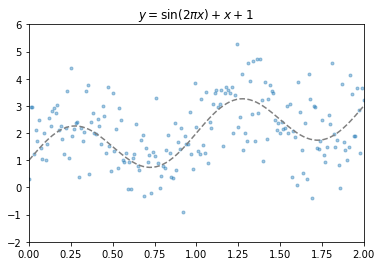

In [374]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2, 201)
y = np.sin(x*np.pi*2) + x + 1
noise = np.random.randn(201)

plt.title(r'$y = \sin(2 \pi x) + x + 1$')
plt.plot(x, y, ls='--', c='grey')
plt.scatter(x, y+noise, marker='.', alpha=.4)
plt.xlim(0, 2)
plt.ylim(-2, 6)

exponentially weighted average:

$\beta = 0.9$\
$v_0 = 0$ ($v_0$: initial value)\
$\theta_1$ ~ $\theta_m$ (actual value)\
$v_1$ ~ $v_m$ (weighted average value)

$$
\begin{align}
v_1 &= \beta v_0 + (1 - \beta) \theta_1\\
v_2 &= \beta v_1 + (1 - \beta) \theta_2\\
v_3 &= \beta v_2 + (1 - \beta) \theta_3\\
\vdots\\
v_{m-1} &= \beta v_{m-2} + (1 - \beta) \theta_{m-1}\\
v_m &= \beta v_{m-1} + (1 - \beta) \theta_m
\end{align}
$$

$$
v_m =
\beta^{m-1}(1 - \beta)\theta_1 +
\beta^{m-2}(1 - \beta)\theta_2 +
\cdots +
\beta(1 - \beta)\theta_{m-1} +
(1 - \beta)\theta_{m}
$$


Sum of geometric progression (GP)
$$
\begin{align}
S_n &= a + ar + ar^2 + \cdots + ar^{n-1}\\
rS_n &= ar + ar^2 + \cdots + ar^{n-1} + ar^n\\
rS_n - S_n &= ar^n - a\\
S_n &= \frac{a(r^n - 1)}{r-1}
\end{align}
$$

$$
\lim_{n \to \infin} S_n =
\begin{dcases}
    \frac{a(r^n - 1)}{r-1} & |r| \geq 1 \\[10pt]
    \frac{a}{1-r} & |r| < 1
\end{dcases}
$$

$$
\lim_{n \to \infin} S_n|_{a = 1-\beta, \, r = \beta} = \frac{1-\beta}{1-\beta} = 1
$$

Bias correction (warm start)

$$
\begin{align*}
    v_m &=
    \beta^{m-1}(1 - \beta)\theta_1 +
    \beta^{m-2}(1 - \beta)\theta_2 +
    \cdots +
    \beta(1 - \beta)\theta_{m-1} +
    (1 - \beta)\theta_{m} \\

    \tilde{v}_m &=
    \frac{
        v_m
    }{
        \beta^{m-1}(1 - \beta) +
        \beta^{m-2}(1 - \beta) +
        \cdots +
        \beta(1 - \beta) +
        (1 - \beta)
    }\\

    &=
    \frac{
        v_m
    }{
        S_m|_{a = 1-\beta, \, r = \beta}
    }\\

    &=
    \dfrac{
        v_m
    }{
        \dfrac{(1-\beta)(\beta^m - 1)}{\beta - 1}
    }\\

    &=
    \dfrac{
        v_m
    }{
        1-\beta^m
    }
\end{align*}
$$

In [375]:
# SGD
thetas = np.random.randn(4) # parameters
for _ in range(100):
    dthetas = np.random.randn(4)
    thetas -= 0.1 * dthetas

# Momentum
beta = 0.9
thetas = np.random.randn(4) # parameters
v = np.zeros_like(thetas) # moving average
for _ in range(100):
    dthetas = np.random.randn(4)
    v = beta*v + (1-beta)*dthetas
    thetas -= 0.1 * v

# Momentum + Bias correction
beta = 0.9
thetas = np.random.randn(4) # parameters
v = np.zeros_like(thetas) # moving average
for i in range(100):
    dthetas = np.random.randn(4)
    v = beta*v + (1-beta)*dthetas / (1 - beta**(i+1))
    thetas -= 0.1 * v

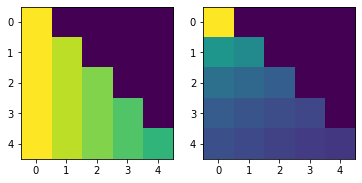

In [376]:
m = 5
beta = 0.9
W = np.ones((m, m,)) * (1 - beta)
W = np.tril(W)

Betas = np.apply_along_axis(lambda x: beta**x, axis=0, arr=np.arange(m)).reshape(1, -1)
W = W * Betas
W_corrected = W / W.sum(1, keepdims=True)

plt.subplot(1,2,1)
plt.imshow(W)

plt.subplot(1,2,2)
plt.imshow(W_corrected)
plt.show()

In [377]:
def createWeights(m, beta=0.9, warm=False):
    assert type(m) is int and m > 0

    even = False
    if m % 2 == 0:
        even = True 
        m += 1
    betas = np.apply_along_axis(lambda x: beta**x, axis=0, arr=np.arange(-(m//2), m-(m//2))).reshape(1, -1)
    Betas = betas * betas.T
    Betas = np.tril(np.flip(Betas, axis=1))
    if even:
        Betas = Betas[1:,1:]
    W = Betas * (1-beta)
    if warm:
        W /= W.sum(1, keepdims=True)

    return W

def getWeightedAverage(x, beta=0.9, warm=False):
    m = len(x)
    W = createWeights(m, beta, warm)
    return (W * x).sum(1)

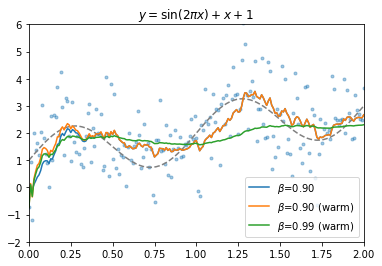

In [378]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2, 201)
y = np.sin(x*np.pi*2) + x + 1
noise = np.random.randn(201)

plt.title(r'$y = \sin(2 \pi x) + x + 1$')
plt.plot(x, y, ls='--', c='grey')
plt.scatter(x, y+noise, marker='.', alpha=.4)
plt.plot(x, getWeightedAverage(y+noise, beta=0.90, warm=False), label=r'$\beta$=0.90')
plt.plot(x, getWeightedAverage(y+noise, beta=0.90, warm=True) , label=r'$\beta$=0.90 (warm)')
plt.plot(x, getWeightedAverage(y+noise, beta=0.99, warm=True) , label=r'$\beta$=0.99 (warm)')
plt.xlim(0, 2)
plt.ylim(-2, 6)
plt.legend()
plt.show()

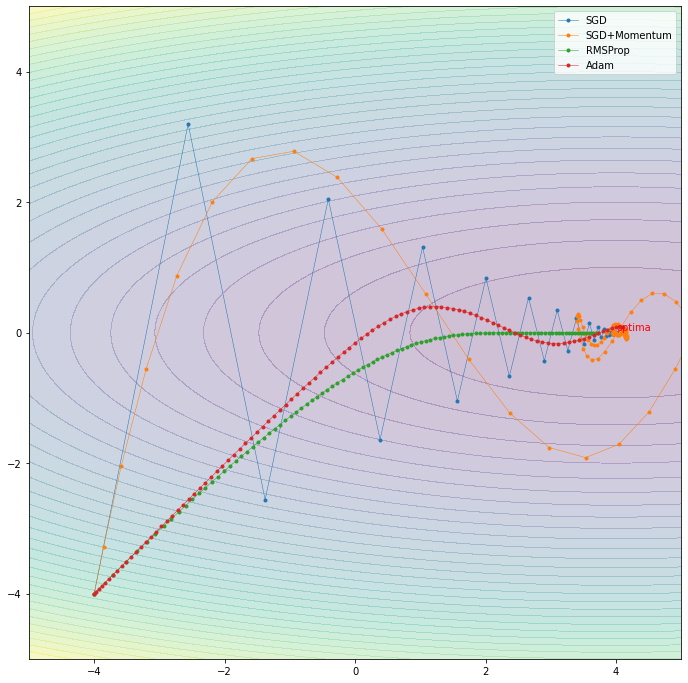

In [379]:
l = np.linspace(-5, 5, 101)
x1_mesh, x2_mesh = np.meshgrid(l, l, indexing='xy')

optima1, optima2 = optima = (4, 0)

def f(x1, x2):
    return 1*(x1-optima1)**2 + 10*(x2-optima2)**2

grad_f = [lambda x1, x2: 2*(x1-optima1), lambda x1, x2: 20*(x2-optima2)]

plt.figure(figsize=(12,12))
plt.contourf(f(x1_mesh, x2_mesh), levels=40, extent=[-5,5,-5,5], alpha=.25)
plt.axis('square')

alpha = .09

# SGD
x_history = [np.array([-4, -4])]
for i in range(100):
    x = x_history[-1]
    dx = list(map(lambda f: f(*x), grad_f))
    dx = np.array(dx)
    x_history.append(x - alpha*dx)
x_history = np.stack(x_history, axis=0)
plt.plot(*x_history.T, lw=.5, marker='.', label='SGD')

# SGD + Momentum (exponentially weighted average)
x_history = [np.array([-4, -4])]
beta = 0.9
v = np.zeros((2,))
for i in range(100):
    x = x_history[-1]
    dx = list(map(lambda f: f(*x), grad_f))
    dx = np.array(dx)
    v = beta*v + (1-beta)*dx
    x_history.append(x - alpha*v)
x_history = np.stack(x_history, axis=0)
plt.plot(*x_history.T, lw=.5, marker='.', label='SGD+Momentum')

# RMSProp
x_history = [np.array([-4, -4])]
beta = 0.9 # set beta to 0 for better understanding
s = np.zeros((2,))
for i in range(100):
    x = x_history[-1]
    dx = list(map(lambda f: f(*x), grad_f))
    dx = np.array(dx)
    s = beta*s + (1-beta)*dx**2
    x_history.append(x - alpha*dx/s**(1/2)) # x-alpha*(dx/dx) when beta=0. This will help backpropagate evenly. almost like choosing between NE, SE, NW, SW
x_history = np.stack(x_history, axis=0)
plt.plot(*x_history.T, lw=.5, marker='.', label='RMSProp')

# Adam (RMSProp + Momentum)
x_history = [np.array([-4, -4])]
beta1 = 0.9
beta2 = 0.9 # 0.999
v = np.zeros((2,))
s = np.zeros((2,))
for i in range(100):
    x = x_history[-1]
    dx = list(map(lambda f: f(*x), grad_f))
    dx = np.array(dx)
    v = beta*v + (1-beta1)*dx
    s = beta*s + (1-beta2)*dx**2
    # bias correction
    # v = v / (1-beta1**(i+1))
    # s = s / (1-beta2**(i+1))
    x_history.append(x - alpha*v/s**(1/2))
x_history = np.stack(x_history, axis=0)
plt.plot(*x_history.T, lw=.5, marker='.', label='Adam')


plt.scatter(*optima, c='r', marker='x')
plt.text(*optima, s='optima', c='r', ha='left', va='bottom') 
plt.legend()
plt.show()